# Assignment 02 for 3D World Representations

In this assignment you will complete two programming tasks and answer 1 written question. You are expected to use Python along with libraries such as **NumPy**, **SciPy**, **Matplotlib**, and **Open3D** (for 3D visualization). Please ensure your code is well-commented and modular.



## 1 Task Based Mapping Methods
Roboticists at the University of Bonn are developing several robots for different applications: 

- **UBoButler**: A humanoid robot tasked with sorting objects on a kitchen counter. The robot must identify and manipulate items like 'cups', 'plates', and 'utensils' and place them in designated locations. It does not wander out of the kitchen.

- **UBoWanderDog**: UBoWanderDog: UBoWanderDog is a quadruped navigating a hilly terrain with obstacles such as 'rocks', 'trees', and 'bushes'. The robot's primary task is to explore the area and map potential paths.

- **UBoAssist**: UBoAssist is a humanoid assisting elderly and visually challenged people in navigation in dense urban areas with pedestrians, cyclists, other vehicles, traffic lights, and crosswalks.

These robots rely on accurate 3D perception to function effectively. Their perception systems process visual data to create 3D maps of their environments. The team is focused on using pixel-level classification from deep learning models to label elements in the scene. To understand the challenges involved, consider the following computational cost considerations:

- **Panoptic Segmentation**: Highest computational cost.

- **Semantic Segmentation**: Provides pixel-level classification of object categories

- **Instance Segmentation**: Similar to Semantic Segmentation but requires additional computation for tracking individual instances.

Determine the most suitable scene understanding approach for mapping (Semantic Segmentation, Instance Segmentation, or Panoptic Segmentation) for each of the three scenarios (Kitchen, Hilly Terrain, and Downtown Area). Justify your choice for each scenario. 

---

#### **UBoButler (Kitchen Scenario)**
**Approach:** Instance Segmentation

**Justification:**
In the kitchen, UBoButler needs to interact with specific individual objects like cups, plates, and utensils. Semantic segmentation alone would only label pixels as "cup" or "plate" without distinguishing between multiple cups or plates, which is insufficient for manipulation tasks. **Instance segmentation** allows the robot to differentiate between individual items, which is crucial for picking and placing actions. Panoptic segmentation would also work but is unnecessarily computationally expensive for a contained environment like a kitchen where there are relatively few objects and low complexity.

---

#### **UBoWanderDog (Hilly Terrain Scenario)**
**Approach:** Semantic Segmentation

**Justification:**
For exploration and navigation in a natural outdoor environment, the goal is to understand general categories of terrain elements like "rock", "tree", and "bush" to plan safe paths. There's no need to distinguish between individual rocks or trees. **Semantic segmentation** provides sufficient information while being computationally lighter than instance or panoptic segmentation, which is important for real-time operation in resource-constrained or field-deployed robots.

---

#### **UBoAssist (Urban Scenario)**
**Approach:** Panoptic Segmentation

**Justification:**
In a dense urban environment, UBoAssist must understand both **what** is in the scene (e.g., traffic lights, pedestrians, cyclists) and **who is who** (e.g., tracking multiple people or vehicles). **Panoptic segmentation**, which combines both semantic and instance segmentation, is ideal here. It allows the robot to perform pixel-level classification while also keeping track of individual dynamic elements, essential for safe and intelligent navigation. Despite its high computational cost, it is justified due to the high complexity and safety-critical nature of the task.

## 2 Semantic Point Cloud Creation and Stitching            

In this task you are provided with a set of depth images, semantic segmentation masks, camera poses, and intrinsics. Your goal is to generate and visualize a colored 3D point cloud. Each depth image should be converted to a local point cloud, colored using the semantic mask and a provided CSV file that maps 41 semantic classes (including background) to RGB colors, and then transformed into world coordinates using the camera pose. Finally, the per-image point clouds should be stitched together and visualized as one global colored point cloud.

- a. Convert each depth image into a 3D point cloud using the camera intrinsics. 

- b. Modify above function to color the point cloud. For each depth, use the corresponding semantic segmentation mask and the provided CSV file mapping semantic classes to colors, to assign an RGB color to each point. Use nearest point interpolation for aligning depth image with segmentation image. Assume segmentation image has same instrinsics as color image. Assume the optical centers for RGB and depth images are co-incident. 

- c. Then, transform the colored local point cloud into world coordinates using the provided camera pose.

- d. Stitch the transformed point clouds from all images into a single global point cloud and visualize it using a 3D visualization tool such as Open3D. 
- e. Explain in text the trade-off between occupancy and TSDF maps on one hand and different grid sizes on the other based on the visualizations generated

### Note:
- Use appropriate libraries (e.g., Open3D) for point cloud creation and visualization.
- Make sure to apply the correct transformations using camera poses and intrinsics.


In [101]:
import numpy as np
import matplotlib
import open3d as o3d

import os
import pandas as pd

In [102]:
def load_data():
    ## Load all the depth images, semantic mask images, camera poses, intrinsics and csv for mapping semantic classes to colors
    color_imgs = []
    depth_imgs = []
    label_imgs = []
    pose_matrices = []
    class_map = {}
    intrinsic_color = []
    intrinsic_depth = []
    
    path = '../assignment_02/task_2/'

    for img in sorted(os.listdir(path + 'color/')):
        color_imgs.append(matplotlib.image.imread(path + 'color/' + img))

    for img in sorted(os.listdir(path + 'depth/')):
        depth_imgs.append(matplotlib.image.imread(path + 'depth/' + img))

    for img in sorted(os.listdir(path + 'label/')):
        label_imgs.append(matplotlib.image.imread(path + 'label/' + img))

    for txt in sorted(os.listdir(path + 'pose/')):
        with open(path + 'pose/' + txt, 'r') as file:
            matrix = [line.strip().split() for line in file]
            matrix = np.array(matrix, float)
        pose_matrices.append(matrix)

    class_map = pd.read_csv('../assignment_02/task_2/class_rgb_map.csv').to_dict()

    with open(path + 'intrinsics_color.txt', 'r') as file:
        intrinsic_color = [line.strip().split() for line in file]
        intrinsic_color = np.array(intrinsic_color, float)

    with open(path + 'intrinsics_depth.txt', 'r') as file:
        intrinsic_depth = [line.strip().split() for line in file]
        intrinsic_depth = np.array(intrinsic_depth, float)
        
    return color_imgs, depth_imgs, label_imgs, pose_matrices, class_map, intrinsic_color, intrinsic_depth

# a.

In [103]:
def convert_depth_to_pointcloud(depth, depth_intrinsics):
    # getting the data of the depth image and intrinsics
    h, w = depth.shape
    fx = depth_intrinsics[0][0]
    fy = depth_intrinsics[1][1]
    cx = depth_intrinsics[0][2]
    cy = depth_intrinsics[1][2]

    point_cloud = []

    # going through the image depth 
    for u in range(w):
        for v in range(h):
            # checking the depth value, if its non zero, make the pointcloud using intrinsics
            z = depth[v][u]
            if z > 0:
                x = z*(u - cx)/fx
                y = z*(v - cy)/fy
                point_cloud.append([x, y, z])

    return np.array(point_cloud)

# b.

In [104]:
def convert_depth_semantics_to_colored_pointcloud(depth, semantics, depth_intrinsics, color_intrinsics, class_map):
    fx_s = color_intrinsics[0][0]
    fy_s = color_intrinsics[1][1]
    cx_s = color_intrinsics[0][2]
    cy_s = color_intrinsics[1][2]

    point_cloud = convert_depth_to_pointcloud(depth, depth_intrinsics)
    point_cloud_rgb = []

    # for each point in the pointcloud, find the nearest point in the semantics using the color intrinsics
    for point in point_cloud:
        u_rgb = int(point[0]*fx_s/point[2] + cx_s)
        v_rgb = int(point[1]*fy_s/point[2] + cy_s)

        # get the rgb color the point is within the semantics image
        label = int(semantics[v_rgb][u_rgb] * 255)
        # create pointcloud in XYZRGB
        point_cloud_rgb.append([point[0], point[1], point[2], class_map['r'][label], class_map['g'][label], class_map['b'][label]])

    return np.array(point_cloud_rgb)

# c.

In [105]:
def transform_pointcloud_to_worldframe(pointcloud, pose):
    # make the pointcloud (just XYZ, no RGB) homogenous
    pointcloud_h = np.hstack((pointcloud[:, :3], np.ones((pointcloud[:, :3].shape[0], 1))))
    # multiply by the pose of the camera
    points_worldframe_h = (pose @ pointcloud_h.T)
    # transform back from homogenous and transpose
    points_worldframe = (points_worldframe_h[:3, :] / points_worldframe_h[3, :]).T
    # append the RGB colors again to the transformed points
    points_worldframe = np.hstack((points_worldframe, pointcloud[:, 3:]))
    return points_worldframe

# d.

In [106]:
def stitch_pointcloud(clouds):
    # all pointclouds in the same array and then as a Nx6 vector (XYZRGB)
    stitched = []
    for cloud in clouds:
        stitched.append(cloud)
    
    stitched = np.vstack(stitched)
    return stitched


In [107]:
def visualize(stitched_cloud):
    # create the pointcloud object
    pcd = o3d.geometry.PointCloud()
    # add points (XYZ) to the point cloud
    pcd.points = o3d.utility.Vector3dVector(stitched_cloud[:, :3])
    # add the mapped colors to the points
    pcd.colors = o3d.utility.Vector3dVector(stitched_cloud[:, 3:6])
    # show the pointcloud on screen
    o3d.visualization.draw_geometries([pcd])

In [108]:
# load all data
imgs_c, imgs_d, labels, poses, classes, color_int, depth_int = load_data()
points = []
# iterate over all images
for i in range(len(imgs_c)):
    # convert the depth images into colored pointcloud
    cloud = convert_depth_semantics_to_colored_pointcloud(imgs_d[i], labels[i], depth_int, color_int, classes)
    # transform pointcloud into worldframe
    # ---------------------------------------------------------------------------------------------------
    # (needs checking into it, commenting it makes more "sense" as everything stays around the same area)
    cloud = transform_pointcloud_to_worldframe(cloud, poses[i])
    # ---------------------------------------------------------------------------------------------------
    # add the points to then stitch them together as a one XYZRGB vector
    points.append(cloud)
stitched = stitch_pointcloud(points)
# visualize the result
visualize(stitched)

## 3. 2D TSDF Grid Generation, Weighted Update and Occupancy Computation ##

In this task you are provided with a defined parabola given by the equation $y=4x^2$, that represents a curved surface in the first quadrant. The scene is defined over a 1m × 1m area with a  user-defined grid cell size i.e. your method should be general to the size. You are also provided with multiple camera poses that indicate the camera’s position and orientation in the scene. Your goal is to generate a 2D Truncated Signed Distance Function (TSDF) grid by performing raycasting from the camera pose(s) into the scene. The TSDF should be computed as follows: along each ray cast from the camera, determine the intersection with the surface defined by $y=4x^2$ (the measured surface).  For a given grid cell along that ray:

- If the cell lies between the camera and the measured surface, assign a positive TSDF value.

- If the cell is beyond the measured surface, assign a negative TSDF. 

- Use TSDF updating principles in the lecture including weight drop-off beyond -0.1m. 

You can refer to state-of-the-art TSDF weight and distance calculation and update methods in the repository https://github.com/ethz-asl/voxblox. 

- a.	Generate the grid covering the 1m × 1m domain with user defined resolution (Use 0.1m for initial testing). Initialize a maps with two values for the grid: TSDF distance and the weight. Also perform suitable initialization of the weights and distances.     

- b.	Using the provided camera pose(s), perform raycasting into the scene. You are given the helper function get_intersection_point(). Compute the TSDF value based on the distance from the cell to the measured surface along that ray using the following convention: cells between the camera and the surface have positive TSDF values, and cells beyond the surface have negative TSDF values. Update the cell’s weight only if its absolute TSDF value is within 0.1m. Document your raycasting method and detail how you use the get_intersection_point() function to determine the surface intersection.
                                                                                            		
- c.	Once the TSDF weights and distances are updated for all poses, generate an occupancy map from the two maps.  
		
- d.	Visualize the TSDF distance, weights and the occupancy maps for two different gride cell sizes 0.1m and 0.01m.  
		
- e.	Explain in text the trade-off between occupancy and TSDF maps on one hand and different grid sizes on the other based on the visualizations generated 

**Note**: You can add helper functions to make the solution modular. However the functions given below must be completed. You can call your helper functions within it. 
		


In [3]:
import numpy as np
import matplotlib.pyplot as plt

##############################
# Configuration and Constants
##############################

config = {
    'use_weight_dropoff': True,
    'default_truncation_distance': 0.1,  # meters
    'max_weight': 100.0,
    'use_const_weight': False
}

kFloatEpsilon = 1e-6

def get_intersection_point(pose, noise_factor=0.001):
    """
    Compute the intersection point of the sensor ray with the parabola defined by:
         y = 4x^2
    The sensor ray is given by: (x, y) + t*(cos(theta), sin(theta)).
    We solve for t from:
         y_cam + t*sin(theta) = 4*(x_cam + t*cos(theta))^2
    and add noise proportional to t. The measured distance is returned as negative,
    but the intersection point is computed using its absolute value.
    """
    x_cam, y_cam, theta = pose

    # Coefficients for the quadratic:
    # 4*cos(theta)^2 * t^2 + (8*x_cam*cos(theta) - sin(theta)) * t + (4*x_cam^2 - y_cam) = 0
    A = 4 * (np.cos(theta)**2)
    B = 8 * x_cam * np.cos(theta) - np.sin(theta)
    C = 4 * (x_cam**2) - y_cam

    discriminant = B**2 - 4 * A * C
    if discriminant < 0:
        t_true = 0
    else:
        t1 = (-B + np.sqrt(discriminant)) / (2 * A)
        t2 = (-B - np.sqrt(discriminant)) / (2 * A)
        candidates = [t for t in [t1, t2] if t > 0]
        t_true = min(candidates) if candidates else 0

    noise = np.random.randn() * noise_factor * t_true
    t_meas = -(t_true + noise)  # negative measured distance

    ray_direction = np.array([np.cos(theta), np.sin(theta)])
    # Compute intersection point using absolute measured distance
    point_G = np.array([x_cam, y_cam]) + (-t_meas) * ray_direction
    return point_G

In [4]:
def load_camera_poses_from_csv_file(csv_file):
    import pandas as pd
    return pd.read_csv(csv_file)
    #pass
camera_poses = load_camera_poses_from_csv_file(f'cameraposes.csv')
print(camera_poses)

           x         y     theta
0   0.735350  2.160618  2.973128
1   0.093559  0.034200  2.211320
2   0.827908  2.728618  2.991395
3   0.635773  1.611480  2.947156
4   0.668193  1.776228  2.956183
5   0.651256  1.690431  2.951640
6   0.209088  0.170999  2.599150
7   0.382406  0.584012  2.825452
8   0.150812  0.090192  2.448251
9   0.875206  3.057137  2.999576
10  0.100808  0.038360  2.244044
11  0.139088  0.075527  2.406185
12  0.120573  0.057291  2.336388
13  0.226171  0.203553  2.635853
14  0.260828  0.267612  2.692042
15  0.829468  2.738679  2.991667
16  0.826769  2.724312  2.991277
17  0.378798  0.568473  2.821565
18  0.267523  0.285569  2.704099
19  0.910417  3.310316  3.005044


In [5]:
def initialize_tsdf_map(grid_size=1.0, cell_size=0.1, config=config):
    # Initialize a tsdf map with 2 values each: weight and distance
    num_cells = int(grid_size / cell_size)
    tsdf_distances = np.full((num_cells, num_cells), config['default_truncation_distance']) # Initialize with max truncation distance
    tsdf_weights = np.zeros((num_cells, num_cells)) # Initialize with zero weights
    return tsdf_distances, tsdf_weights
    
tsdf_distances, tsdf_weights = initialize_tsdf_map()
print(tsdf_distances)
print(tsdf_weights)

[[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [6]:
def update_tsdf_map(camera_pose, tsdf_distances, tsdf_weights, grid_size=1.0, cell_size=0.1, config=config):
    # Update the tsdf map's weight and distances where applicable for the current camera pose
    # Use the get_intersection_point() function in above cell to get the intersection point with the parabola which is the surface point
    x_cam, y_cam, theta = camera_pose

    truncation = config['default_truncation_distance']
    max_weight = config['max_weight']

    intersection_point = get_intersection_point(camera_pose)

    direction = np.array([np.cos(theta), np.sin(theta)])
    start_point = np.array([x_cam, y_cam])
    end_point = intersection_point
    ray = end_point - start_point
    ray_length = np.linalg.norm(ray)

    num_steps = max(int(ray_length / (cell_size / 2)), 1)

    for i in range(num_steps):
        t = i / num_steps
        point = start_point + t * ray
        x, y = point

        if not (0 <= x < grid_size and 0 <= y < grid_size):
            continue

        ix = int(x / cell_size)
        iy = int(y / cell_size)

        cell_center = np.array([ix * cell_size + cell_size / 2,
                                iy * cell_size + cell_size / 2])

        signed_distance = np.dot(end_point - cell_center, direction)

        if abs(signed_distance) > truncation:
            continue

        tsdf_value = np.clip(signed_distance / truncation, -1.0, 1.0)

        # TSDF weighted update
        w_old = tsdf_weights[iy, ix]
        d_old = tsdf_distances[iy, ix]

        w_new = w_old + 1
        tsdf_updated = (w_old * d_old + tsdf_value) / w_new

        tsdf_distances[iy, ix] = tsdf_updated
        tsdf_weights[iy, ix] = min(w_new, max_weight)

Raycasting Method and Utilization of get_intersection_point() function

Firstly, I extracted the camerapose from csv file and then used get_intersection_point() function to get the point on actual surface seen from this pose. Then computed the unit vector direction of ray using theta of camera pose and then computed the vector from camera to surface as well as its length.
Then examined the ray along cells by breaking it into smaller parts. If the ray is outside the map then we skip it. Otherwise, we calculate the location of the point on the current cell as well as center of the cell. 
After this we get the vector from cell center to the surface. To get the signed distance from this cell center to the surface we  use inner product of this vector with direction vector of camera pose to the surface. Then we check if absolute value of this signed distance is less than truncation threshold or not. If it is then we normalize the distance with truncation threshold to keep tsdf value in the range of -1 to 1.
Consequently, we do weighted average update of weight and distance of this particular cell.

In [7]:
def compute_occupancy_map(tsdf_distances, weight_threshold=0.01,  config=config):
    # Compute occupancy map from the tsdf map's weights and distances. If weight < 0.01, assume occupancy is 0.5 i.e. unknown
    occupancy_map = np.full_like(tsdf_distances, 0.5)  # Unknown by default
    occupied_thresh = 0.05
    trunc = config['default_truncation_distance']

    known = tsdf_weights >= weight_threshold
    occupied = known & (np.abs(tsdf_distances) <= occupied_thresh)
    free = known & (np.abs(tsdf_distances) > trunc)

    occupancy_map[occupied] = 1.0
    occupancy_map[free] = 0.0

    return occupancy_map
occupancy_map = compute_occupancy_map(tsdf_distances)
print(occupancy_map)

[[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
 [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]]


In [8]:
def visualize_tsdf_weight(tsdf_weights):
    plt.imshow(tsdf_weights, cmap='viridis')
    plt.title('TSDF Weights')
    plt.colorbar()
    plt.show()

In [9]:
def visualize_tsdf_dist(tsdf_distances):
    plt.imshow(tsdf_distances, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('TSDF Distances')
    plt.colorbar()
    plt.show()

In [10]:
def visualize_occupancy_map(occupancy_map):
    plt.imshow(occupancy_map, cmap='gray', vmin=0, vmax=1)
    plt.title('Occupancy Map')
    plt.colorbar()
    plt.show()

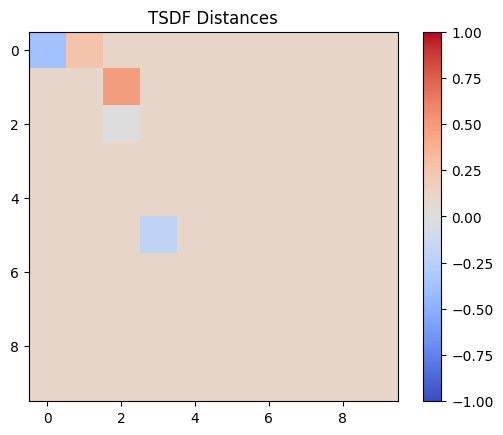

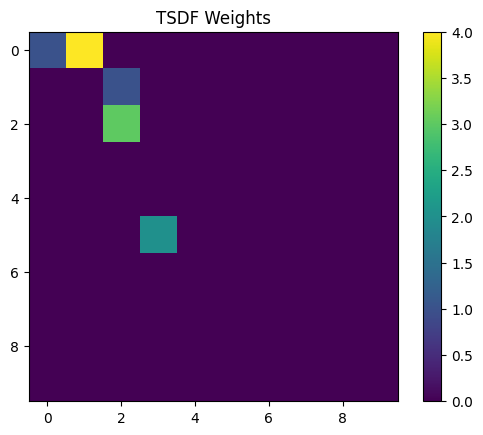

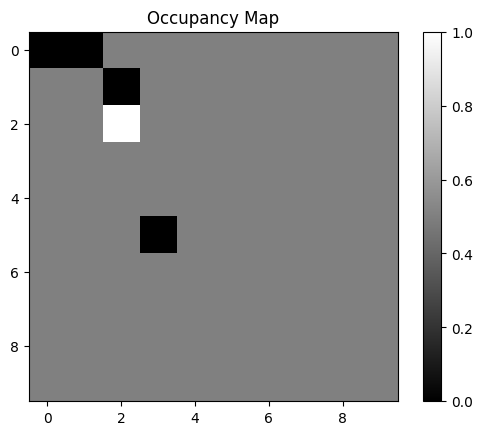

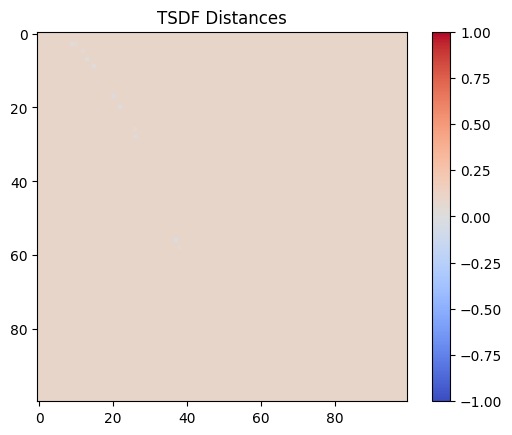

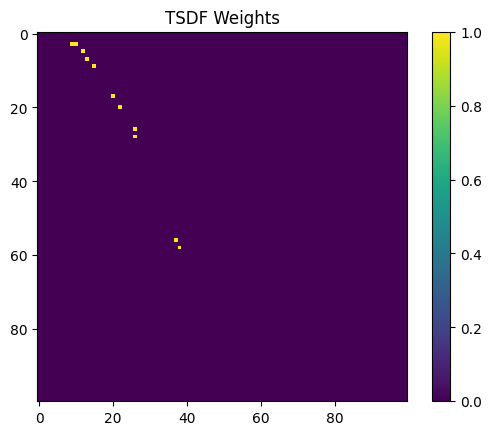

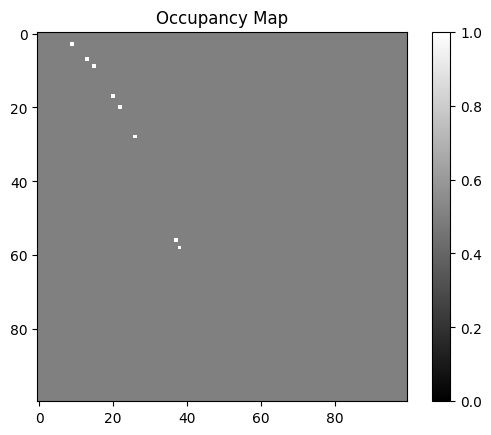

In [11]:
if __name__ == '__main__':

## Call all the funcs here
    cell_size = 0.1
    tsdf_distances, tsdf_weights = initialize_tsdf_map(cell_size=cell_size)

    for _, row in camera_poses.iterrows():
        pose = row[['x', 'y', 'theta']].values
        #tsdf_dist_weight = update_tsdf_map(pose, tsdf_distances, tsdf_weights, cell_size=cell_size)
        update_tsdf_map(pose, tsdf_distances, tsdf_weights, cell_size=cell_size)
        #print(tsdf_distances)

    occupancy_map = compute_occupancy_map(tsdf_distances, tsdf_weights)
    visualize_tsdf_dist(tsdf_distances)
    visualize_tsdf_weight(tsdf_weights)
    visualize_occupancy_map(occupancy_map)

    #Visualization for cell size 0.01
    cell_size = 0.01
    tsdf_distances, tsdf_weights = initialize_tsdf_map(cell_size=cell_size)

    for _, row in camera_poses.iterrows():
        pose = row[['x', 'y', 'theta']].values
        #tsdf_dist_weight = update_tsdf_map(pose, tsdf_distances, tsdf_weights, cell_size=cell_size)
        update_tsdf_map(pose, tsdf_distances, tsdf_weights, cell_size=cell_size)
        #print(tsdf_distances)

    occupancy_map = compute_occupancy_map(tsdf_distances, tsdf_weights)
    visualize_tsdf_dist(tsdf_distances)
    visualize_tsdf_weight(tsdf_weights)
    visualize_occupancy_map(occupancy_map)

The trade-off between occupancy and TSDF maps for different grid sizes

TSDF maps with higher cell size show fewer updated cells where ray passes through very few discrete cells, whereas in case of smaller cell size TSDF maps shows more cells on the rays as evident through TSDF weights visualizations.

Similarly, Occupancy maps show same coverage pattern in both cases of different cell sizes, however, in case of smaller cell size the continuous change is more visual.

Apart from that, we don't see any changes for TSDF distances on smaller cell size visualization because when we reduce the cell size with factor of 10 the number of grid cells increase drastically with the factor of 100 (inversely proportinal to the square of cell sizes). Therefore, we get small tsdf values near to 0 and eventually updated tsdf values stay same as the old ones.